In [22]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Softmax
from keras.models import Sequential

def get_base_model():
    base_mobilenet_model = MobileNet(input_shape =  (128,128,1), 
                                     include_top = False, weights = None)
    multi_disease_model = Sequential()
    multi_disease_model.add(base_mobilenet_model)
    multi_disease_model.add(GlobalAveragePooling2D())
    multi_disease_model.add(Dropout(0.5))
    multi_disease_model.add(Dense(512))
    multi_disease_model.add(Dropout(0.5))
    multi_disease_model.add(Dense(13, activation = 'sigmoid'))
    multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['binary_accuracy', 'mae'])
    multi_disease_model.summary()
    multi_disease_model.load_weights('/Users/gursharan/Desktop/xray_class_weights.best.hdf5')
    return multi_disease_model;

In [13]:
model = get_base_model()
added_layers = 3
model.add(Dense(20, activation = 'sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.add(Softmax())
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy', 'mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 13)                6669      
_________________________________________________________________
dense_7 (Dense)              (None, 20)               

In [14]:
#Get the images
import csv
xrays = '/Users/gursharan/Desktop/covid-chest-xray/'
disease_to_file = [];
for row in csv.reader(open(xrays + '/metadata.csv','r')):
    #finding is #4 and filename is #21
    #modality is #17 and view is $16
    if( row[17] != 'X-ray' and row[16] != 'PA' ):
        continue
    disease_to_file.append( [ row[4],row[21] ] );

In [15]:
import os
xrays_dir = xrays + '/images/'
if not os.path.exists(xrays_dir + '/covid'):
    os.mkdir(xrays_dir + '/covid')
if not os.path.exists(xrays_dir + '/not_covid'):
    os.mkdir(xrays_dir + '/not_covid')

In [16]:
#Get the images
xrays = '/Users/gursharan/Desktop/covid-chest-xray/'
xrays_raw = xrays + '/images_raw/'
xrays_seg = xrays + '/images/'

import shutil
for [ finding, filename ] in disease_to_file:
    directory = '/not_covid/'
    if finding == 'COVID-19':
        directory = '/covid/'
    if( os.path.exists(xrays_raw + filename) ):
        shutil.copy2( xrays_raw + filename, xrays_seg + directory + filename)

In [17]:
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet as mnet

datagen = ImageDataGenerator(
    preprocessing_function=mnet.preprocess_input, shear_range=0.5, zoom_range=0.5,
    horizontal_flip=True, validation_split=0.1)

ensure_folder_exists('training_aug')
ensure_folder_exists('validation_aug')

training = datagen.flow_from_directory( xrays_seg, target_size=(128, 128),                                    
    color_mode = 'grayscale', save_to_dir='./training_aug', subset='training')
validation = datagen.flow_from_directory( xrays_seg, target_size=(128, 128),
    color_mode = 'grayscale', save_to_dir='./validation_aug', subset='validation') 

Found 236 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


In [19]:
from keras_tqdm import TQDMNotebookCallback

batch_size = 32
history = model.fit_generator(
    generator=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=50,
    callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/50


7/7 [==============================] - 14s 2s/step - loss: 0.6371 - binary_accuracy: 0.7500 - mae: 0.4695 - val_loss: 0.6361 - val_binary_accuracy: 0.7308 - val_mae: 0.4664
Epoch 2/50


7/7 [==============================] - 13s 2s/step - loss: 0.6346 - binary_accuracy: 0.7143 - mae: 0.4640 - val_loss: 0.6241 - val_binary_accuracy: 0.7308 - val_mae: 0.4572
Epoch 3/50


7/7 [==============================] - 11s 2s/step - loss: 0.6152 - binary_accuracy: 0.7228 - mae: 0.4563 - val_loss: 0.6181 - val_binary_accuracy: 0.7308 - val_mae: 0.4522
Epoch 4/50


7/7 [==============================] - 13s 2s/step - loss: 0.6217 - binary_accuracy: 0.7188 - mae: 0.4532 - val_loss: 0.6137 - val_binary_accuracy: 0.7308 - val_mae: 0.4483
Epoch 5/50


7/7 [==============================] - 13s 2s/step - loss: 0.6030 - binary_accuracy: 0.7500 - mae: 0.4421 - val_loss: 0.6096 - val_binary_accuracy: 0.7308 - val_mae: 0.4444
Epoch 6/50


7/7 [==============================] - 12s 2s/step - loss: 0.5983 - binary_accuracy: 0.7500 - mae: 0.4381 - val_loss: 0.6062 - val_binary_accuracy: 0.7308 - val_mae: 0.4409
Epoch 7/50


7/7 [==============================] - 11s 2s/step - loss: 0.6043 - binary_accuracy: 0.7283 - mae: 0.4402 - val_loss: 0.6033 - val_binary_accuracy: 0.7308 - val_mae: 0.4377
Epoch 8/50


7/7 [==============================] - 17s 2s/step - loss: 0.6013 - binary_accuracy: 0.7321 - mae: 0.4361 - val_loss: 0.6008 - val_binary_accuracy: 0.7308 - val_mae: 0.4349
Epoch 9/50


7/7 [==============================] - 21s 3s/step - loss: 0.6047 - binary_accuracy: 0.7353 - mae: 0.4327 - val_loss: 0.5987 - val_binary_accuracy: 0.7308 - val_mae: 0.4323
Epoch 10/50


7/7 [==============================] - 18s 3s/step - loss: 0.6148 - binary_accuracy: 0.7206 - mae: 0.4345 - val_loss: 0.5973 - val_binary_accuracy: 0.7308 - val_mae: 0.4306
Epoch 11/50


7/7 [==============================] - 21s 3s/step - loss: 0.6001 - binary_accuracy: 0.7451 - mae: 0.4256 - val_loss: 0.5959 - val_binary_accuracy: 0.7308 - val_mae: 0.4288
Epoch 12/50


7/7 [==============================] - 21s 3s/step - loss: 0.5975 - binary_accuracy: 0.7277 - mae: 0.4291 - val_loss: 0.5948 - val_binary_accuracy: 0.7308 - val_mae: 0.4272
Epoch 13/50


7/7 [==============================] - 19s 3s/step - loss: 0.5860 - binary_accuracy: 0.7500 - mae: 0.4205 - val_loss: 0.5938 - val_binary_accuracy: 0.7308 - val_mae: 0.4257
Epoch 14/50


7/7 [==============================] - 20s 3s/step - loss: 0.5943 - binary_accuracy: 0.7206 - mae: 0.4282 - val_loss: 0.5928 - val_binary_accuracy: 0.7308 - val_mae: 0.4241
Epoch 15/50


7/7 [==============================] - 20s 3s/step - loss: 0.5777 - binary_accuracy: 0.7451 - mae: 0.4187 - val_loss: 0.5918 - val_binary_accuracy: 0.7308 - val_mae: 0.4226
Epoch 16/50


7/7 [==============================] - 20s 3s/step - loss: 0.5969 - binary_accuracy: 0.7206 - mae: 0.4254 - val_loss: 0.5910 - val_binary_accuracy: 0.7308 - val_mae: 0.4213
Epoch 17/50


7/7 [==============================] - 21s 3s/step - loss: 0.5894 - binary_accuracy: 0.7451 - mae: 0.4158 - val_loss: 0.5903 - val_binary_accuracy: 0.7308 - val_mae: 0.4201
Epoch 18/50


7/7 [==============================] - 21s 3s/step - loss: 0.6216 - binary_accuracy: 0.6961 - mae: 0.4318 - val_loss: 0.5899 - val_binary_accuracy: 0.7308 - val_mae: 0.4193
Epoch 19/50


7/7 [==============================] - 21s 3s/step - loss: 0.5704 - binary_accuracy: 0.7647 - mae: 0.4070 - val_loss: 0.5894 - val_binary_accuracy: 0.7308 - val_mae: 0.4184
Epoch 20/50


7/7 [==============================] - 22s 3s/step - loss: 0.5849 - binary_accuracy: 0.7366 - mae: 0.4159 - val_loss: 0.5888 - val_binary_accuracy: 0.7308 - val_mae: 0.4173
Epoch 21/50


7/7 [==============================] - 17s 2s/step - loss: 0.6165 - binary_accuracy: 0.7065 - mae: 0.4257 - val_loss: 0.5884 - val_binary_accuracy: 0.7308 - val_mae: 0.4166
Epoch 22/50


7/7 [==============================] - 23s 3s/step - loss: 0.5635 - binary_accuracy: 0.7634 - mae: 0.4044 - val_loss: 0.5881 - val_binary_accuracy: 0.7308 - val_mae: 0.4158
Epoch 23/50


7/7 [==============================] - 18s 3s/step - loss: 0.5939 - binary_accuracy: 0.7206 - mae: 0.4192 - val_loss: 0.5877 - val_binary_accuracy: 0.7308 - val_mae: 0.4151
Epoch 24/50


7/7 [==============================] - 20s 3s/step - loss: 0.5952 - binary_accuracy: 0.7255 - mae: 0.4167 - val_loss: 0.5874 - val_binary_accuracy: 0.7308 - val_mae: 0.4144
Epoch 25/50


7/7 [==============================] - 19s 3s/step - loss: 0.5798 - binary_accuracy: 0.7255 - mae: 0.4161 - val_loss: 0.5871 - val_binary_accuracy: 0.7308 - val_mae: 0.4137
Epoch 26/50


7/7 [==============================] - 14s 2s/step - loss: 0.5894 - binary_accuracy: 0.7277 - mae: 0.4146 - val_loss: 0.5868 - val_binary_accuracy: 0.7308 - val_mae: 0.4131
Epoch 27/50


7/7 [==============================] - 9s 1s/step - loss: 0.5559 - binary_accuracy: 0.7500 - mae: 0.4055 - val_loss: 0.5865 - val_binary_accuracy: 0.7308 - val_mae: 0.4123
Epoch 28/50


7/7 [==============================] - 12s 2s/step - loss: 0.6140 - binary_accuracy: 0.6964 - mae: 0.4251 - val_loss: 0.5862 - val_binary_accuracy: 0.7308 - val_mae: 0.4117
Epoch 29/50


7/7 [==============================] - 11s 2s/step - loss: 0.5487 - binary_accuracy: 0.7794 - mae: 0.3928 - val_loss: 0.5860 - val_binary_accuracy: 0.7308 - val_mae: 0.4111
Epoch 30/50


7/7 [==============================] - 11s 2s/step - loss: 0.5685 - binary_accuracy: 0.7451 - mae: 0.4052 - val_loss: 0.5857 - val_binary_accuracy: 0.7308 - val_mae: 0.4104
Epoch 31/50


7/7 [==============================] - 12s 2s/step - loss: 0.6049 - binary_accuracy: 0.7108 - mae: 0.4180 - val_loss: 0.5856 - val_binary_accuracy: 0.7308 - val_mae: 0.4099
Epoch 32/50


7/7 [==============================] - 11s 2s/step - loss: 0.5754 - binary_accuracy: 0.7353 - mae: 0.4080 - val_loss: 0.5854 - val_binary_accuracy: 0.7308 - val_mae: 0.4095
Epoch 33/50


7/7 [==============================] - 11s 2s/step - loss: 0.5715 - binary_accuracy: 0.7402 - mae: 0.4056 - val_loss: 0.5852 - val_binary_accuracy: 0.7308 - val_mae: 0.4090
Epoch 34/50


7/7 [==============================] - 13s 2s/step - loss: 0.5691 - binary_accuracy: 0.7500 - mae: 0.4012 - val_loss: 0.5851 - val_binary_accuracy: 0.7308 - val_mae: 0.4085
Epoch 35/50


7/7 [==============================] - 10s 1s/step - loss: 0.6051 - binary_accuracy: 0.7065 - mae: 0.4180 - val_loss: 0.5850 - val_binary_accuracy: 0.7308 - val_mae: 0.4082
Epoch 36/50


7/7 [==============================] - 12s 2s/step - loss: 0.5762 - binary_accuracy: 0.7411 - mae: 0.4040 - val_loss: 0.5849 - val_binary_accuracy: 0.7308 - val_mae: 0.4079
Epoch 37/50


7/7 [==============================] - 12s 2s/step - loss: 0.6238 - binary_accuracy: 0.6863 - mae: 0.4256 - val_loss: 0.5848 - val_binary_accuracy: 0.7308 - val_mae: 0.4076
Epoch 38/50


7/7 [==============================] - 12s 2s/step - loss: 0.5646 - binary_accuracy: 0.7549 - mae: 0.3979 - val_loss: 0.5847 - val_binary_accuracy: 0.7308 - val_mae: 0.4074
Epoch 39/50


7/7 [==============================] - 12s 2s/step - loss: 0.5704 - binary_accuracy: 0.7402 - mae: 0.4035 - val_loss: 0.5846 - val_binary_accuracy: 0.7308 - val_mae: 0.4071
Epoch 40/50


7/7 [==============================] - 12s 2s/step - loss: 0.5758 - binary_accuracy: 0.7402 - mae: 0.4031 - val_loss: 0.5845 - val_binary_accuracy: 0.7308 - val_mae: 0.4067
Epoch 41/50


7/7 [==============================] - 12s 2s/step - loss: 0.5833 - binary_accuracy: 0.7321 - mae: 0.4060 - val_loss: 0.5844 - val_binary_accuracy: 0.7308 - val_mae: 0.4063
Epoch 42/50


7/7 [==============================] - 10s 1s/step - loss: 0.5740 - binary_accuracy: 0.7337 - mae: 0.4050 - val_loss: 0.5843 - val_binary_accuracy: 0.7308 - val_mae: 0.4061
Epoch 43/50


7/7 [==============================] - 12s 2s/step - loss: 0.5831 - binary_accuracy: 0.7321 - mae: 0.4054 - val_loss: 0.5842 - val_binary_accuracy: 0.7308 - val_mae: 0.4058
Epoch 44/50


7/7 [==============================] - 11s 2s/step - loss: 0.5793 - binary_accuracy: 0.7353 - mae: 0.4039 - val_loss: 0.5842 - val_binary_accuracy: 0.7308 - val_mae: 0.4056
Epoch 45/50


7/7 [==============================] - 12s 2s/step - loss: 0.5866 - binary_accuracy: 0.7402 - mae: 0.4016 - val_loss: 0.5841 - val_binary_accuracy: 0.7308 - val_mae: 0.4053
Epoch 46/50


7/7 [==============================] - 11s 2s/step - loss: 0.6041 - binary_accuracy: 0.7255 - mae: 0.4074 - val_loss: 0.5841 - val_binary_accuracy: 0.7308 - val_mae: 0.4052
Epoch 47/50


7/7 [==============================] - 10s 1s/step - loss: 0.5890 - binary_accuracy: 0.7283 - mae: 0.4062 - val_loss: 0.5840 - val_binary_accuracy: 0.7308 - val_mae: 0.4051
Epoch 48/50


7/7 [==============================] - 13s 2s/step - loss: 0.5789 - binary_accuracy: 0.7366 - mae: 0.4026 - val_loss: 0.5840 - val_binary_accuracy: 0.7308 - val_mae: 0.4049
Epoch 49/50


7/7 [==============================] - 13s 2s/step - loss: 0.5517 - binary_accuracy: 0.7549 - mae: 0.3948 - val_loss: 0.5839 - val_binary_accuracy: 0.7308 - val_mae: 0.4046
Epoch 50/50


7/7 [==============================] - 12s 2s/step - loss: 0.5851 - binary_accuracy: 0.7206 - mae: 0.4087 - val_loss: 0.5839 - val_binary_accuracy: 0.7308 - val_mae: 0.4044



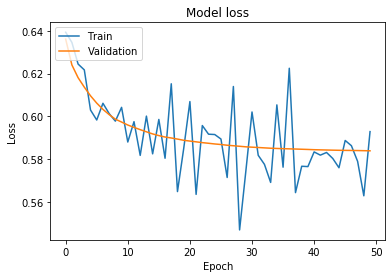

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

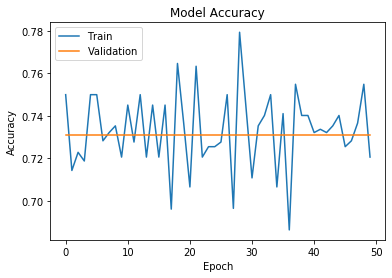

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# not much luck :(
# for one, we need more data!!! We only have around 300 xray images.
### We notice that accuracy keeps oscillating, maybe we are stuck at local minima...let's try NADAM!

In [26]:
import tensorflow as tf
model.compile(optimizer =tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
              loss = 'binary_crossentropy', metrics = ['binary_accuracy', 'mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 13)                6669      
_________________________________________________________________
dense_7 (Dense)              (None, 20)               

In [27]:
#is datagen reusable?
datagen = ImageDataGenerator(
    preprocessing_function=mnet.preprocess_input, shear_range=0.5, zoom_range=0.5,
    horizontal_flip=True, validation_split=0.1)
training = datagen.flow_from_directory( xrays_seg, target_size=(128, 128),                                    
    color_mode = 'grayscale', save_to_dir='./training_aug', subset='training')
validation = datagen.flow_from_directory( xrays_seg, target_size=(128, 128),
    color_mode = 'grayscale', save_to_dir='./validation_aug', subset='validation') 

batch_size = 32
history = model.fit_generator(
    generator=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=50,
    callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Found 236 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


Epoch 1/50


7/7 [==============================] - 15s 2s/step - loss: 0.5787 - binary_accuracy: 0.7366 - mae: 0.4014 - val_loss: 0.5836 - val_binary_accuracy: 0.7308 - val_mae: 0.4035
Epoch 2/50


7/7 [==============================] - 12s 2s/step - loss: 0.5967 - binary_accuracy: 0.7206 - mae: 0.4081 - val_loss: 0.5836 - val_binary_accuracy: 0.7308 - val_mae: 0.4034
Epoch 3/50


7/7 [==============================] - 10s 1s/step - loss: 0.5963 - binary_accuracy: 0.7337 - mae: 0.4019 - val_loss: 0.5836 - val_binary_accuracy: 0.7308 - val_mae: 0.4031
Epoch 4/50


7/7 [==============================] - 12s 2s/step - loss: 0.5862 - binary_accuracy: 0.7402 - mae: 0.3990 - val_loss: 0.5835 - val_binary_accuracy: 0.7308 - val_mae: 0.4027
Epoch 5/50


7/7 [==============================] - 11s 2s/step - loss: 0.6002 - binary_accuracy: 0.7304 - mae: 0.4028 - val_loss: 0.5835 - val_binary_accuracy: 0.7308 - val_mae: 0.4026
Epoch 6/50


7/7 [==============================] - 13s 2s/step - loss: 0.5782 - binary_accuracy: 0.7366 - mae: 0.3999 - val_loss: 0.5834 - val_binary_accuracy: 0.7308 - val_mae: 0.4022
Epoch 7/50


7/7 [==============================] - 11s 2s/step - loss: 0.5823 - binary_accuracy: 0.7304 - mae: 0.4021 - val_loss: 0.5833 - val_binary_accuracy: 0.7308 - val_mae: 0.4018
Epoch 8/50


7/7 [==============================] - 12s 2s/step - loss: 0.5841 - binary_accuracy: 0.7353 - mae: 0.3996 - val_loss: 0.5832 - val_binary_accuracy: 0.7308 - val_mae: 0.4014
Epoch 9/50


7/7 [==============================] - 12s 2s/step - loss: 0.5883 - binary_accuracy: 0.7304 - mae: 0.4012 - val_loss: 0.5832 - val_binary_accuracy: 0.7308 - val_mae: 0.4011
Epoch 10/50


7/7 [==============================] - 11s 2s/step - loss: 0.5697 - binary_accuracy: 0.7451 - mae: 0.3948 - val_loss: 0.5831 - val_binary_accuracy: 0.7308 - val_mae: 0.4007
Epoch 11/50


7/7 [==============================] - 12s 2s/step - loss: 0.6208 - binary_accuracy: 0.7059 - mae: 0.4116 - val_loss: 0.5831 - val_binary_accuracy: 0.7308 - val_mae: 0.4009
Epoch 12/50


7/7 [==============================] - 12s 2s/step - loss: 0.5325 - binary_accuracy: 0.7857 - mae: 0.3769 - val_loss: 0.5830 - val_binary_accuracy: 0.7308 - val_mae: 0.4001
Epoch 13/50


7/7 [==============================] - 11s 2s/step - loss: 0.6150 - binary_accuracy: 0.7059 - mae: 0.4110 - val_loss: 0.5830 - val_binary_accuracy: 0.7308 - val_mae: 0.4002
Epoch 14/50


7/7 [==============================] - 11s 2s/step - loss: 0.5822 - binary_accuracy: 0.7283 - mae: 0.4011 - val_loss: 0.5830 - val_binary_accuracy: 0.7308 - val_mae: 0.3999
Epoch 15/50


7/7 [==============================] - 12s 2s/step - loss: 0.6066 - binary_accuracy: 0.7054 - mae: 0.4109 - val_loss: 0.5830 - val_binary_accuracy: 0.7308 - val_mae: 0.4000
Epoch 16/50


7/7 [==============================] - 12s 2s/step - loss: 0.5610 - binary_accuracy: 0.7549 - mae: 0.3895 - val_loss: 0.5829 - val_binary_accuracy: 0.7308 - val_mae: 0.3996
Epoch 17/50


7/7 [==============================] - 12s 2s/step - loss: 0.5903 - binary_accuracy: 0.7206 - mae: 0.4041 - val_loss: 0.5829 - val_binary_accuracy: 0.7308 - val_mae: 0.3995
Epoch 18/50


7/7 [==============================] - 11s 2s/step - loss: 0.5607 - binary_accuracy: 0.7549 - mae: 0.3887 - val_loss: 0.5828 - val_binary_accuracy: 0.7308 - val_mae: 0.3989
Epoch 19/50


7/7 [==============================] - 13s 2s/step - loss: 0.5817 - binary_accuracy: 0.7321 - mae: 0.3985 - val_loss: 0.5828 - val_binary_accuracy: 0.7308 - val_mae: 0.3989
Epoch 20/50


7/7 [==============================] - 12s 2s/step - loss: 0.6048 - binary_accuracy: 0.7108 - mae: 0.4077 - val_loss: 0.5829 - val_binary_accuracy: 0.7308 - val_mae: 0.3993
Epoch 21/50


7/7 [==============================] - 11s 2s/step - loss: 0.5757 - binary_accuracy: 0.7304 - mae: 0.3992 - val_loss: 0.5828 - val_binary_accuracy: 0.7308 - val_mae: 0.3989
Epoch 22/50


7/7 [==============================] - 11s 2s/step - loss: 0.5970 - binary_accuracy: 0.7059 - mae: 0.4096 - val_loss: 0.5828 - val_binary_accuracy: 0.7308 - val_mae: 0.3987
Epoch 23/50


7/7 [==============================] - 12s 2s/step - loss: 0.5685 - binary_accuracy: 0.7598 - mae: 0.3858 - val_loss: 0.5828 - val_binary_accuracy: 0.7308 - val_mae: 0.3985
Epoch 24/50


7/7 [==============================] - 12s 2s/step - loss: 0.5708 - binary_accuracy: 0.7500 - mae: 0.3900 - val_loss: 0.5828 - val_binary_accuracy: 0.7308 - val_mae: 0.3983
Epoch 25/50


7/7 [==============================] - 12s 2s/step - loss: 0.5670 - binary_accuracy: 0.7402 - mae: 0.3940 - val_loss: 0.5827 - val_binary_accuracy: 0.7308 - val_mae: 0.3980
Epoch 26/50


7/7 [==============================] - 11s 2s/step - loss: 0.5865 - binary_accuracy: 0.7108 - mae: 0.4069 - val_loss: 0.5827 - val_binary_accuracy: 0.7308 - val_mae: 0.3979
Epoch 27/50


7/7 [==============================] - 12s 2s/step - loss: 0.5558 - binary_accuracy: 0.7598 - mae: 0.3849 - val_loss: 0.5827 - val_binary_accuracy: 0.7308 - val_mae: 0.3975
Epoch 28/50


7/7 [==============================] - 12s 2s/step - loss: 0.5942 - binary_accuracy: 0.7188 - mae: 0.4029 - val_loss: 0.5827 - val_binary_accuracy: 0.7308 - val_mae: 0.3975
Epoch 29/50


7/7 [==============================] - 11s 2s/step - loss: 0.5729 - binary_accuracy: 0.7402 - mae: 0.3932 - val_loss: 0.5827 - val_binary_accuracy: 0.7308 - val_mae: 0.3973
Epoch 30/50


7/7 [==============================] - 11s 2s/step - loss: 0.5774 - binary_accuracy: 0.7337 - mae: 0.3960 - val_loss: 0.5827 - val_binary_accuracy: 0.7308 - val_mae: 0.3972
Epoch 31/50


7/7 [==============================] - 12s 2s/step - loss: 0.5813 - binary_accuracy: 0.7321 - mae: 0.3965 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3971
Epoch 32/50


7/7 [==============================] - 11s 2s/step - loss: 0.5815 - binary_accuracy: 0.7304 - mae: 0.3972 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3970
Epoch 33/50


7/7 [==============================] - 11s 2s/step - loss: 0.5690 - binary_accuracy: 0.7304 - mae: 0.3970 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3968
Epoch 34/50


7/7 [==============================] - 11s 2s/step - loss: 0.5641 - binary_accuracy: 0.7500 - mae: 0.3882 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3967
Epoch 35/50


7/7 [==============================] - 12s 2s/step - loss: 0.5856 - binary_accuracy: 0.7277 - mae: 0.3981 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3967
Epoch 36/50


7/7 [==============================] - 11s 2s/step - loss: 0.5987 - binary_accuracy: 0.7228 - mae: 0.4002 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3967
Epoch 37/50


7/7 [==============================] - 12s 2s/step - loss: 0.5534 - binary_accuracy: 0.7549 - mae: 0.3859 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3965
Epoch 38/50


7/7 [==============================] - 13s 2s/step - loss: 0.6071 - binary_accuracy: 0.7054 - mae: 0.4079 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3966
Epoch 39/50


7/7 [==============================] - 11s 2s/step - loss: 0.5965 - binary_accuracy: 0.7206 - mae: 0.4011 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3966
Epoch 40/50


7/7 [==============================] - 12s 2s/step - loss: 0.5723 - binary_accuracy: 0.7549 - mae: 0.3858 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3965
Epoch 41/50


7/7 [==============================] - 11s 2s/step - loss: 0.6023 - binary_accuracy: 0.7353 - mae: 0.3945 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3965
Epoch 42/50


7/7 [==============================] - 12s 2s/step - loss: 0.5728 - binary_accuracy: 0.7402 - mae: 0.3923 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3965
Epoch 43/50


7/7 [==============================] - 12s 2s/step - loss: 0.5733 - binary_accuracy: 0.7255 - mae: 0.3989 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3964
Epoch 44/50


7/7 [==============================] - 13s 2s/step - loss: 0.5683 - binary_accuracy: 0.7455 - mae: 0.3897 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3963
Epoch 45/50


7/7 [==============================] - 11s 2s/step - loss: 0.5878 - binary_accuracy: 0.7304 - mae: 0.3965 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3963
Epoch 46/50


7/7 [==============================] - 13s 2s/step - loss: 0.5864 - binary_accuracy: 0.7108 - mae: 0.4053 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3962
Epoch 47/50


7/7 [==============================] - 11s 2s/step - loss: 0.5790 - binary_accuracy: 0.7402 - mae: 0.3920 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3962
Epoch 48/50


7/7 [==============================] - 11s 2s/step - loss: 0.5708 - binary_accuracy: 0.7353 - mae: 0.3942 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3961
Epoch 49/50


7/7 [==============================] - 13s 2s/step - loss: 0.5726 - binary_accuracy: 0.7411 - mae: 0.3915 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3961
Epoch 50/50


7/7 [==============================] - 10s 1s/step - loss: 0.5925 - binary_accuracy: 0.7228 - mae: 0.3997 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3961



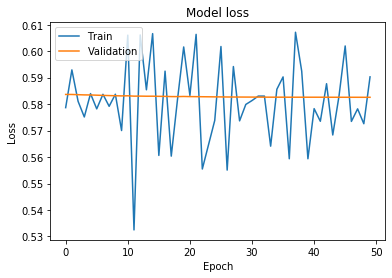

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

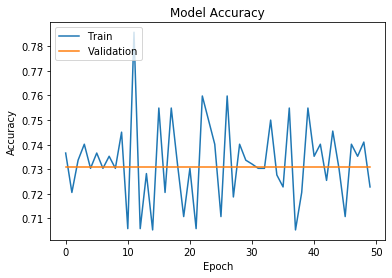

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
#is datagen reusable?
datagen = ImageDataGenerator(
    preprocessing_function=mnet.preprocess_input, shear_range=0.5, zoom_range=0.5,
    horizontal_flip=True, validation_split=0.1)
training = datagen.flow_from_directory( xrays_seg, target_size=(128, 128),                                    
    color_mode = 'grayscale', save_to_dir='./training_aug', subset='training', shuffle=True)
validation = datagen.flow_from_directory( xrays_seg, target_size=(128, 128),
    color_mode = 'grayscale', save_to_dir='./validation_aug', subset='validation', shuffle=True) 

batch_size = 32
history = model.fit_generator(
    generator=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=50,
    callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Found 236 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


Epoch 1/50


7/7 [==============================] - 12s 2s/step - loss: 0.5644 - binary_accuracy: 0.7353 - mae: 0.3939 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3959
Epoch 2/50


7/7 [==============================] - 11s 2s/step - loss: 0.6029 - binary_accuracy: 0.7206 - mae: 0.4006 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3960
Epoch 3/50


7/7 [==============================] - 13s 2s/step - loss: 0.5986 - binary_accuracy: 0.7143 - mae: 0.4034 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3960
Epoch 4/50


7/7 [==============================] - 10s 1s/step - loss: 0.5691 - binary_accuracy: 0.7283 - mae: 0.3971 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3959
Epoch 5/50


7/7 [==============================] - 13s 2s/step - loss: 0.5378 - binary_accuracy: 0.7768 - mae: 0.3751 - val_loss: 0.5826 - val_binary_accuracy: 0.7308 - val_mae: 0.3958
Epoch 6/50


7/7 [==============================] - 12s 2s/step - loss: 0.5776 - binary_accuracy: 0.7206 - mae: 0.4004 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3957
Epoch 7/50


7/7 [==============================] - 11s 2s/step - loss: 0.5966 - binary_accuracy: 0.7206 - mae: 0.4003 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3957
Epoch 8/50


7/7 [==============================] - 12s 2s/step - loss: 0.5682 - binary_accuracy: 0.7451 - mae: 0.3892 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3956
Epoch 9/50


7/7 [==============================] - 13s 2s/step - loss: 0.5725 - binary_accuracy: 0.7411 - mae: 0.3910 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3956
Epoch 10/50


7/7 [==============================] - 10s 1s/step - loss: 0.6052 - binary_accuracy: 0.7228 - mae: 0.3992 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3956
Epoch 11/50


7/7 [==============================] - 13s 2s/step - loss: 0.5507 - binary_accuracy: 0.7634 - mae: 0.3808 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3955
Epoch 12/50


7/7 [==============================] - 11s 2s/step - loss: 0.6052 - binary_accuracy: 0.7228 - mae: 0.3992 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3956
Epoch 13/50


7/7 [==============================] - 11s 2s/step - loss: 0.6010 - binary_accuracy: 0.7157 - mae: 0.4024 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3956
Epoch 14/50


7/7 [==============================] - 12s 2s/step - loss: 0.6162 - binary_accuracy: 0.7059 - mae: 0.4069 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3957
Epoch 15/50


7/7 [==============================] - 13s 2s/step - loss: 0.5682 - binary_accuracy: 0.7455 - mae: 0.3890 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3957
Epoch 16/50


7/7 [==============================] - 12s 2s/step - loss: 0.5663 - binary_accuracy: 0.7402 - mae: 0.3914 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3956
Epoch 17/50


7/7 [==============================] - 12s 2s/step - loss: 0.5746 - binary_accuracy: 0.7451 - mae: 0.3891 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3956
Epoch 18/50


7/7 [==============================] - 12s 2s/step - loss: 0.5966 - binary_accuracy: 0.7206 - mae: 0.4002 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3956
Epoch 19/50


7/7 [==============================] - 12s 2s/step - loss: 0.5839 - binary_accuracy: 0.7206 - mae: 0.4002 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3955
Epoch 20/50


7/7 [==============================] - 13s 2s/step - loss: 0.5899 - binary_accuracy: 0.7232 - mae: 0.3989 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3955
Epoch 21/50


7/7 [==============================] - 12s 2s/step - loss: 0.5309 - binary_accuracy: 0.7794 - mae: 0.3734 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3954
Epoch 22/50


7/7 [==============================] - 11s 2s/step - loss: 0.5991 - binary_accuracy: 0.7108 - mae: 0.4045 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3954
Epoch 23/50


7/7 [==============================] - 12s 2s/step - loss: 0.5834 - binary_accuracy: 0.7353 - mae: 0.3934 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3954
Epoch 24/50


7/7 [==============================] - 12s 2s/step - loss: 0.5941 - binary_accuracy: 0.7304 - mae: 0.3955 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3954
Epoch 25/50


7/7 [==============================] - 12s 2s/step - loss: 0.5745 - binary_accuracy: 0.7451 - mae: 0.3889 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3954
Epoch 26/50


7/7 [==============================] - 11s 2s/step - loss: 0.6251 - binary_accuracy: 0.6961 - mae: 0.4111 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3955
Epoch 27/50


7/7 [==============================] - 13s 2s/step - loss: 0.5638 - binary_accuracy: 0.7500 - mae: 0.3867 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3954
Epoch 28/50


7/7 [==============================] - 11s 2s/step - loss: 0.5746 - binary_accuracy: 0.7446 - mae: 0.3892 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3954
Epoch 29/50


7/7 [==============================] - 12s 2s/step - loss: 0.5768 - binary_accuracy: 0.7366 - mae: 0.3927 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3954
Epoch 30/50


7/7 [==============================] - 12s 2s/step - loss: 0.6094 - binary_accuracy: 0.7206 - mae: 0.4000 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3954
Epoch 31/50


7/7 [==============================] - 12s 2s/step - loss: 0.5858 - binary_accuracy: 0.7255 - mae: 0.3978 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3954
Epoch 32/50


7/7 [==============================] - 12s 2s/step - loss: 0.5682 - binary_accuracy: 0.7451 - mae: 0.3889 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3954
Epoch 33/50


7/7 [==============================] - 13s 2s/step - loss: 0.5768 - binary_accuracy: 0.7366 - mae: 0.3927 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3953
Epoch 34/50


7/7 [==============================] - 10s 1s/step - loss: 0.5880 - binary_accuracy: 0.7283 - mae: 0.3965 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3953
Epoch 35/50


7/7 [==============================] - 13s 2s/step - loss: 0.5725 - binary_accuracy: 0.7411 - mae: 0.3906 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3953
Epoch 36/50


7/7 [==============================] - 13s 2s/step - loss: 0.5902 - binary_accuracy: 0.7206 - mae: 0.3999 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3953
Epoch 37/50


7/7 [==============================] - 10s 1s/step - loss: 0.5862 - binary_accuracy: 0.7228 - mae: 0.3989 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3953
Epoch 38/50


7/7 [==============================] - 12s 2s/step - loss: 0.5943 - binary_accuracy: 0.7188 - mae: 0.4007 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3953
Epoch 39/50


7/7 [==============================] - 12s 2s/step - loss: 0.5593 - binary_accuracy: 0.7549 - mae: 0.3843 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3952
Epoch 40/50


7/7 [==============================] - 12s 2s/step - loss: 0.5853 - binary_accuracy: 0.7402 - mae: 0.3909 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3952
Epoch 41/50


7/7 [==============================] - 12s 2s/step - loss: 0.5986 - binary_accuracy: 0.7255 - mae: 0.3976 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3952
Epoch 42/50


7/7 [==============================] - 12s 2s/step - loss: 0.5637 - binary_accuracy: 0.7500 - mae: 0.3865 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3952
Epoch 43/50


7/7 [==============================] - 12s 2s/step - loss: 0.5662 - binary_accuracy: 0.7402 - mae: 0.3909 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3952
Epoch 44/50


7/7 [==============================] - 13s 2s/step - loss: 0.5900 - binary_accuracy: 0.7232 - mae: 0.3986 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3951
Epoch 45/50


7/7 [==============================] - 12s 2s/step - loss: 0.6055 - binary_accuracy: 0.7108 - mae: 0.4042 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3952
Epoch 46/50


7/7 [==============================] - 11s 2s/step - loss: 0.5918 - binary_accuracy: 0.7391 - mae: 0.3914 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3952
Epoch 47/50


7/7 [==============================] - 13s 2s/step - loss: 0.5856 - binary_accuracy: 0.7277 - mae: 0.3966 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3952
Epoch 48/50


7/7 [==============================] - 12s 2s/step - loss: 0.5637 - binary_accuracy: 0.7500 - mae: 0.3865 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3952
Epoch 49/50


7/7 [==============================] - 12s 2s/step - loss: 0.5667 - binary_accuracy: 0.7255 - mae: 0.3975 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3951
Epoch 50/50


7/7 [==============================] - 13s 2s/step - loss: 0.5592 - binary_accuracy: 0.7549 - mae: 0.3841 - val_loss: 0.5825 - val_binary_accuracy: 0.7308 - val_mae: 0.3950



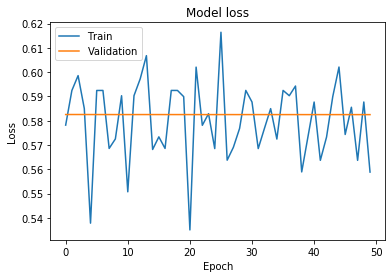

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Even with shuffling of data, no luck!

## This now does seem more likely to be data problem.